# TD7 - Analyse de texte - correction

Analyse de texte, TF-IDF, LDA, moteur de recherche, expressions régulières (correction).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Récupération des données

Il est possible de télécharger les données [df_pocket.zip](http://www.xavierdupre.fr/enseignement/complements/df_pocket.zip).

In [2]:
from pyensae.datasource import download_data
download_data("df_pocket.zip")

['data_pocket.json', 'df_pocket.csv']

## Nettoyer les données (regexp et nltk)

Mais avant tout, nous devrions augmenter la qualité de nos données (en améliorant les parsers et la liste des stopwords). C'est l'objet de cette section.

In [3]:
import json
from pprint import pprint

with open('./data_pocket.json') as fp:    
    dict_pocket = json.load(fp)
dict_to_df = {}

keys = ['resolved_url', 'resolved_title', 'excerpt', 'tags']

for (k,v) in dict_pocket.items():
    dict_to_df[k] = dict(zip(keys, [v[key] for key in keys if key in v]))
import pandas as p
df_pocket = p.DataFrame.from_dict(dict_to_df, orient = "index")
df_pocket.head()

,resolved_url,resolved_title,excerpt,tags
1883956314,http://www.xavierdupre.fr/app/teachpyx/helpsph...,Types et variables du langage python¶,Il est impossible d’écrire un programme sans u...,"{'python': {'item_id': '1883956314', 'tag': 'p..."
1895830689,https://www.pluralsight.com/paths/javascript?a...,JavaScript,ES6 is a major update to the JavaScript langua...,NaN
1916603293,http://www.seloger.com/annonces/locations/appa...,"Location Appartement 56,88m² Asnieres-sur-Sein...","Prix au m² fourni à titre indicatif, seul un p...",NaN
1916600800,http://www.seloger.com/annonces/locations/appa...,Location Appartement 82m² Asnieres sur Seine -...,Trouvez votre bien à tout moment ...,NaN
1916598390,http://www.seloger.com/annonces/locations/appa...,"Location Appartement 93,6m² Asnières-sur-Seine",Trouvez votre bien à tout moment ...,NaN


In [4]:
import pandas as p
import ast
df_pocket = p.read_csv('./df_pocket.csv')
df_pocket.head()

,tags,url,excerpt,title,domain,html_soup
0,['mobile app'],https://www.grafikart.fr/tutoriels/cordova/ion...,Ionic est un framework qui va vous permettre d...,Tutoriel Vidéo Apache CordovaIonic Framework,grafikart.fr,"{'h2': ['Petit', 'tour', 'du', 'propriétaire']..."
1,['lewagon'],http://www.colorhunt.co,Home Create Likes () About Add To Chrome Faceb...,Color Hunt,colorhunt.co,{}
2,['data science'],https://jakevdp.github.io/blog/2015/08/14/out-...,"In recent months, a host of new tools and pack...",Out-of-Core Dataframes in Python: Dask and Ope...,jakevdp.github.io,"{'h2': ['Pubs', 'of', 'the', 'British', 'Isles..."
3,['abtest'],https://blog.dominodatalab.com/ab-testing-with...,"In this post, I discuss a method for A/B testi...",A/B Testing with Hierarchical Models in Python,blog.dominodatalab.com,"{'h2': ['Recent', 'Posts'], 'h3': ['Related'],..."
4,"['mdn', 'documentation']",https://developer.mozilla.org/en-US/docs/Learn...,Getting started with the Web is a concise seri...,Getting started with the Web,developer.mozilla.org,"{'h2': ['Mozilla'], 'h3': ['How', 'the', 'web'..."


In [5]:
df_pocket['html_soup'] = df_pocket['html_soup'].apply(lambda x : ast.literal_eval(x) if x != "scraper banned" else x)
df_pocket['tags'] = df_pocket['tags'].apply(lambda x : ast.literal_eval(x) if x == x else x)
df_pocket.head()

,tags,url,excerpt,title,domain,html_soup
0,[mobile app],https://www.grafikart.fr/tutoriels/cordova/ion...,Ionic est un framework qui va vous permettre d...,Tutoriel Vidéo Apache CordovaIonic Framework,grafikart.fr,"{'h2': ['Petit', 'tour', 'du', 'propriétaire']..."
1,[lewagon],http://www.colorhunt.co,Home Create Likes () About Add To Chrome Faceb...,Color Hunt,colorhunt.co,{}
2,[data science],https://jakevdp.github.io/blog/2015/08/14/out-...,"In recent months, a host of new tools and pack...",Out-of-Core Dataframes in Python: Dask and Ope...,jakevdp.github.io,"{'h2': ['Pubs', 'of', 'the', 'British', 'Isles..."
3,[abtest],https://blog.dominodatalab.com/ab-testing-with...,"In this post, I discuss a method for A/B testi...",A/B Testing with Hierarchical Models in Python,blog.dominodatalab.com,"{'h2': ['Recent', 'Posts'], 'h3': ['Related'],..."
4,"[mdn, documentation]",https://developer.mozilla.org/en-US/docs/Learn...,Getting started with the Web is a concise seri...,Getting started with the Web,developer.mozilla.org,"{'h2': ['Mozilla'], 'h3': ['How', 'the', 'web'..."


In [6]:
def nan_to_string(x):
    if x==x:
        return x
    else:
        return ''

title_string = ' '.join(df_pocket['title'].apply( lambda x: nan_to_string(x)))

In [7]:
import re
def url_cleaning(url):
    return ' '.join(re.split(r'\/|\.|\:|-|\?',url))

url_string = ' '.join(df_pocket['url'].apply(lambda x : url_cleaning(x)))

In [8]:
def hx_cleaning(d,hx):
    if str(hx) in d:
        return ' '.join(d[str(hx)])
    else: 
        return ''
     
h1_string = ' '.join(df_pocket['html_soup'].apply(lambda x : hx_cleaning(x,'h1')))

In [9]:
h2_string = ' '.join(df_pocket['html_soup'].apply(lambda x : hx_cleaning(x,'h2')))
h3_string = ' '.join(df_pocket['html_soup'].apply(lambda x : hx_cleaning(x, 'h3')))
excerpt_string = ' '.join(df_pocket['excerpt'].apply( lambda x: nan_to_string(x)))

In [10]:
def p_cleaning(x):
    if (type(x) == dict) & ('p' in x ):
        return ' '.join(x['p'])
    else: 
        return ''

p_string = ' '.join(df_pocket['html_soup'].apply(lambda x : p_cleaning(x)))

In [11]:
words = ' '.join([title_string,url_string,h1_string,h2_string,h3_string,excerpt_string])
# on ne conserve que les mots
words_string = re.sub('[^A-Za-z ]','', words)
#on "nettoie les espaces"
words_string = re.sub('\s+',' ', words_string)
words_string[:1000] + '...'

'Tutoriel Vido Apache CordovaIonic Framework Color Hunt OutofCore Dataframes in Python Dask and OpenStreetMap AB Testing with Hierarchical Models in Python Getting started with the Web Le Wagon UI components shakacodereactonrails Le Wagon Alumni Nocturne Opus No Frederic Chopin Piano Tutorial Synthesia ES Promises in Depth Jupyter Notebook Viewer Introduction lanalyse de texte avec nltk Tokenization CamFind API Documentation Build an Elasticsearch Index with PythonMachine Learning Series Part The MustHave Discovery Tool for every Media Professional Python NLTK WTF Chapter Notes on things that dont work right Google Maps Geolocation Tracking in Realtime with JavaScript The Definitive Guide to Natural Language Processing lewagonrailsstylesheets Productivity Tips for Programmers with ADHD EquityOwl No Cash No Salaries Just Equity React For Beginners Learn Enough Text Editor to Be Dangerous Michael Hartl Mapbox The New WordPresscom Why Proxima Nova Is Everywhere PayByPhone Adds NFC in San 

In [12]:
! pip install nltk

Defaulting to user installation because normal site-packages is not writeable


Nltk contient un corpus de stopwords en plusieurs langues. On peut enrichir la liste déjà créée.

In [13]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
print(STOPWORDS)

{'her', "i'd", 'than', 'under', 'yours', 'such', "haven't", "doesn't", "didn't", 'then', "couldn't", 'myself', 'from', 'since', 'are', 'have', 'again', 'the', 'did', 'being', 'which', 'be', 'yourself', 'am', 'here', "weren't", "he's", 'himself', 'ought', 'for', "you're", 'because', 'how', 'about', 'that', 'he', 'theirs', 'she', 'those', 'after', "shan't", 'other', 'ours', 'so', 'very', 'between', "how's", 'you', "when's", "she'd", 'above', "he'd", 'with', "we're", "shouldn't", 'www', 'should', 'in', 'like', 'down', 'hence', 'own', "they'd", 'any', 'but', 'as', 'was', "aren't", "won't", 'r', 'hers', 'them', "mustn't", 'this', 'too', 'most', 'not', 'through', "let's", "she's", 'all', 'up', 'get', 'do', 'both', 'been', "that's", "you've", "he'll", "isn't", 'is', 'further', "wasn't", "wouldn't", 'has', 'once', 'out', 'our', 'when', 'yourselves', 'until', 'also', 'otherwise', 'can', 'more', 'during', "here's", 'only', 'however', 'no', 'it', "hasn't", 'same', 'herself', "they'll", 'itself', 

In [14]:
for wds in ['http', 'https', 'www', 'fr', 'com', 'io', 'org', 'co', 'jo', 'edu', 'news', 'html', 'htm',\
            'github', 'youtube', 'google', 'blog', 'watch', 'de', 'le', 'la', 'en', 'sur', 'vous', 'les', \
           'ajouter', 'README', 'md', 'et', 'PROCESS', 'CMYK', 'des', 'chargement', 'playlists', 'endobj', \
           'obj','est', 'use', 'using', 'will', 'web', 'first','pour', 'du', 'une', 'que']:
    stopwords.add(wds)

In [15]:
import nltk

stopwords_fr_ntlk = set(nltk.corpus.stopwords.words('french'))
stopwords_en_ntlk = set(nltk.corpus.stopwords.words('english'))
stopwords_clean = [ l.lower() for l in list(stopwords.union(stopwords_fr_ntlk).union(stopwords_en_ntlk))]
stopwords_clean[:50] + ['...']

['her',
 'sont',
 'under',
 'such',
 "haven't",
 'jo',
 'then',
 'myself',
 'fussiez',
 'sa',
 'fr',
 'haven',
 'again',
 'md',
 'étées',
 'the',
 'un',
 'did',
 'seront',
 'par',
 'playlists',
 'yourself',
 've',
 "he's",
 'himself',
 'use',
 'ma',
 'ses',
 'about',
 'he',
 'theirs',
 'she',
 'ayant',
 'en',
 'news',
 'other',
 'll',
 'weren',
 'et',
 'so',
 'between',
 'you',
 'dans',
 "when's",
 'aies',
 't',
 "she'd",
 'with',
 'étants',
 "that'll",
 '...']

In [16]:
%matplotlib inline

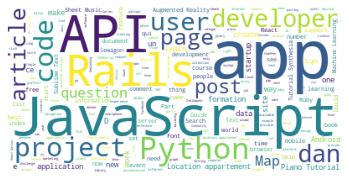

In [17]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white")

wordcloud.generate(words_string)

import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis('off');

On applique tout ça à df_pocket.

In [18]:
def words_cleaning(url,title,excerpt,html_soup):
    url_clean = url_cleaning(url)
    title_clean = nan_to_string(title)
    excerpt_clean = nan_to_string(excerpt)
    h1_clean = hx_cleaning(html_soup,'h1')
    h2_clean = hx_cleaning(html_soup,'h2')
    h3_clean = hx_cleaning(html_soup,'h3')
    p_clean = p_cleaning(html_soup)
    words = ' '.join([url_clean, title_clean, excerpt_clean, h1_clean, h2_clean, h3_clean, p_clean])
    words_clean = re.sub('[^A-Za-z ]','', words)
    words_clean = re.sub('\s+',' ', words_clean)
    words_list = words_clean.split(' ')
    return ' '.join([w.lower() for w in words_list if w not in stopwords_clean])

In [19]:
import numpy as np
df_pocket['words_string'] = np.vectorize(words_cleaning)(df_pocket['url'], \
                                                         df_pocket['title'], \
                                                         df_pocket['excerpt'], \
                                                         df_pocket['html_soup'])
df_pocket.head()

,tags,url,excerpt,title,domain,html_soup,words_string
0,[mobile app],https://www.grafikart.fr/tutoriels/cordova/ion...,Ionic est un framework qui va vous permettre d...,Tutoriel Vidéo Apache CordovaIonic Framework,grafikart.fr,"{'h2': ['Petit', 'tour', 'du', 'propriétaire']...",grafikart tutoriels cordova ionic framework tu...
1,[lewagon],http://www.colorhunt.co,Home Create Likes () About Add To Chrome Faceb...,Color Hunt,colorhunt.co,{},colorhunt color hunt home create likes about a...
2,[data science],https://jakevdp.github.io/blog/2015/08/14/out-...,"In recent months, a host of new tools and pack...",Out-of-Core Dataframes in Python: Dask and Ope...,jakevdp.github.io,"{'h2': ['Pubs', 'of', 'the', 'British', 'Isles...",jakevdp core dataframes python outofcore dataf...
3,[abtest],https://blog.dominodatalab.com/ab-testing-with...,"In this post, I discuss a method for A/B testi...",A/B Testing with Hierarchical Models in Python,blog.dominodatalab.com,"{'h2': ['Recent', 'Posts'], 'h3': ['Related'],...",dominodatalab ab testing hierarchical models p...
4,"[mdn, documentation]",https://developer.mozilla.org/en-US/docs/Learn...,Getting started with the Web is a concise seri...,Getting started with the Web,developer.mozilla.org,"{'h2': ['Mozilla'], 'h3': ['How', 'the', 'web'...",developer mozilla us docs learn gettingstarted...


A présent la base df_pocket est nettoyée et prête à être utilisée pour les analyses de textes. 

## Analyse des données textuelles - TD-IDF, similarité cosine et n-grams

Le calcul [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (term frequency–inverse document frequency) permet de calculer un score de proximité entre un terme de recherche et un document (c'est ce que font les moteurs de recherche). 


La partie tf calcule une fonction croissante de la fréquence du terme de recherche dans le document à l'étude, la partie idf calcule une fonction inversement proportionnelle à la fréquence du terme dans l'ensemble des documents (ou corpus). 



Le score total, obtenu en multipliant les deux composantes, permet ainsi de donner un score d'autant plus élevé que le terme est surréprésenté dans un document (par rapport à l'ensemble des documents). Il existe plusieurs fonctions, qui pénalisent plus ou moins les documents longs, ou qui sont plus ou moins smooth.

In [20]:
corpus = { 
    'a' : "Mr. Green killed Colonel Mustard in the study with the candlestick. "
          "Mr. Green is not a very nice fellow.",
    'b' : "Professor Plum has a green plant in his study.",
    'c' : "Miss Scarlett watered Professor Plum's green plant while he was away "
          "from his office last week."
}
terms = {
    'a' : [ i.lower() for i in corpus['a'].split() ],
    'b' : [ i.lower() for i in corpus['b'].split() ],
    'c' : [ i.lower() for i in corpus['c'].split() ]
}

In [21]:
from math import log

QUERY_TERMS = ['mr.', 'green']

def tf(term, doc, normalize=True):
    doc = doc.lower().split()
    if normalize:
        return doc.count(term.lower()) / float(len(doc))
    else:
        return doc.count(term.lower()) / 1.0


def idf(term, corpus):
    num_texts_with_term = len([True for text in corpus if term.lower() \
                              in text.lower().split()])
    try:
        return 1.0 + log(float(len(corpus)) / num_texts_with_term)
    except ZeroDivisionError:
        return 1.0
    
def tf_idf(term, doc, corpus):
    return tf(term, doc) * idf(term, corpus)

In [22]:
for (k, v) in sorted(corpus.items()):
    print(k, ':', v)
print('\n')

query_scores = {'a': 0, 'b': 0, 'c': 0}
for term in [t.lower() for t in QUERY_TERMS]:
    for doc in sorted(corpus):
        print('TF({}): {}'.format(doc, term), tf(term, corpus[doc]))
    print('IDF: {}'.format(term, ), idf(term, corpus.values()))
    print('\n')
    for doc in sorted(corpus):
        score = tf_idf(term, corpus[doc], corpus.values())
        print('TF-IDF({}): {}'.format(doc, term), score)
        query_scores[doc] += score
    print('\n')

print("Score TF-IDF total pour le terme '{}'".format(' '.join(QUERY_TERMS), ))
for (doc, score) in sorted(query_scores.items()):
    print(doc, score)

a : Mr. Green killed Colonel Mustard in the study with the candlestick. Mr. Green is not a very nice fellow.
b : Professor Plum has a green plant in his study.
c : Miss Scarlett watered Professor Plum's green plant while he was away from his office last week.


TF(a): mr. 0.10526315789473684
TF(b): mr. 0.0
TF(c): mr. 0.0
IDF: mr. 2.09861228866811


TF-IDF(a): mr. 0.22090655670190631
TF-IDF(b): mr. 0.0
TF-IDF(c): mr. 0.0


TF(a): green 0.10526315789473684
TF(b): green 0.1111111111111111
TF(c): green 0.0625
IDF: green 1.0


TF-IDF(a): green 0.10526315789473684
TF-IDF(b): green 0.1111111111111111
TF-IDF(c): green 0.0625


Score TF-IDF total pour le terme 'mr. green'
a 0.3261697145966431
b 0.1111111111111111
c 0.0625


## Exercice guidé - Calcul de TF-IDF 

Quel document est le plus proche du terme "green plant" ? Calculer les scores TF-IDF pour le terme "green plant". Cela correspond-il à vos attentes ? Que se passe-t-il avec "green" seul ?

### Green plant

In [23]:

from math import log

def tf(term, doc, normalize=True):
    doc = doc.lower().split()
    if normalize:
        return doc.count(term.lower()) / float(len(doc))
    else:
        return doc.count(term.lower()) / 1.0


def idf(term, corpus):
    num_texts_with_term = len([True for text in corpus if term.lower()
                              in text.lower().split()])
    try:
        return 1.0 + log(float(len(corpus)) / num_texts_with_term)
    except ZeroDivisionError:
        return 1.0

def tf_idf(term, doc, corpus):
    return tf(term, doc) * idf(term, corpus)



In [24]:
QUERY_TERMS = ['green', 'plant']
query_scores = {'a': 0, 'b': 0, 'c': 0}
for term in [t.lower() for t in QUERY_TERMS]:
    for doc in sorted(corpus):
        score = tf_idf(term, corpus[doc], corpus.values())
        query_scores[doc] += score

print("Score TF-IDF total pour le terme '{}'".format(' '.join(QUERY_TERMS), ))
for (doc, score) in sorted(query_scores.items()):
    print(doc, score)

Score TF-IDF total pour le terme 'green plant'
a 0.10526315789473684
b 0.26727390090090714
c 0.1503415692567603


Deux documents possibles : b ou c (a ne contient pas le mot « plant »). B est plus court : donc green plant « pèse » plus.

### Green

In [25]:
QUERY_TERMS = ['green']
term = [t.lower() for t in QUERY_TERMS]
term = 'green'

query_scores = {'a': 0, 'b': 0, 'c': 0}

for doc in sorted(corpus):
    score = tf_idf(term, corpus[doc], corpus.values())
    query_scores[doc] += score

print("Score TF-IDF total pour le terme '{}'".format(term))
for (doc, score) in sorted(query_scores.items()):
    print(doc, score)

Score TF-IDF total pour le terme 'green'
a 0.10526315789473684
b 0.1111111111111111
c 0.0625


### Exercice 1 - TF-IDF sur des données pocket

Prenez 5 articles enregistrés dans pocket et déterminer leur score pour les mots python, data et science.

### Exercice 2 - Création d'un moteur de recherche pour les données pocket

L'idée de cet exercice est de créer un moteur de recherche pour ['python','data','science']. 

Le but : trouver les 5 articles les plus pertinents pour ces termes. 

    1) La première étape sera de calculer pour chaque article de la base le score td-idf.

    2) La seconde étape sera de trier ces scores du plus élevé au moins fort. 

### Exercice 3 - Catégorisation automatique avec des méthodes non supervisées

Avec ce que vous venez d'apprendre (le tf-idf), il est possible de créer un modèle de catégorisation automatique "non-supervisé". Ce terme barbare signifie que l'on peut créér des tags à partir des seules variables explicatives, sans utiliser de "label", c'est-à-dire de données qui valident si la prédiction (ici, présence de tel ou tel mot dans les tags) est correcte. Normalement, on utilise ce genre de méthode quand on a pas de labels et que l'on cherche à faire ressortir des régularités (des patterns) dans les données. D'autres méthodes de machine learning non-supervisées connues sont : le clustering, les ACP.

Pour bien comprendre le tf-idf, on vous l'a fait coder "à la main". En réalité, c'est tellement classique, qu'il existe des librairies qui l'ont déjà codé. Voir [scikitlearn.feature_extraction.text](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

L'idée est la suivante : on va retenir comme "tags", les 3 mots les plus "caractéristiques" d'un document. C'est-à-dire, les mots correspondants aux 3 scores tf-idf les plus élevés.

Les étapes à suivre : 
- transformer les mots en vecteurs. L'idée est de créer une matrice, avec en ligne les documents, en colonne les mots possibles (prendre tous le smots uniques présents dans l'ensemble des documents). Cela se fait en 3 lignes de code, voir la documentation [scikitlearn.feature_extraction.text](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
- calculer les tf-idf normalisés
- récupérer les indices dont les mots ont le score le plus élevé : voir la méthode [argsort](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argsort.html)
- récupérer la correspondance mots et indices
- récupérer les 3 mots les plus caractéristiques, et comparer aux tags de la table df_pocket

# Approche contextuelle

Les approches bag-of-words, bien que simplistes, permettent de créer, d'indexer et de comparer des documents. La prise en compte des suites de 2, 3 ou plus mots serait un moyen d'affiner de tels modèles. Cela permet aussi de mieux comprendre le sens des homonymes, et des phrases (d'une manière générale, la sémantique).

nltk offre des methodes pour tenir compte du contexte : pour ce faire, nous calculons les n-grams, c'est-à-dire l'ensemble des co-occurrences successives de mots deux-à-deux (bigrams), trois-à-trois (tri-grams), etc. 

En général, on se contente de bi-grams, au mieux de tri-grams : 
- les modèles de classification, analyse du sentiment, comparaison de documents, etc. qui comparent des n-grams avec n trop grands sont rapidement confrontés au problème de données sparse, cela réduit la capacité prédictive des modèles ; 
- les performances décroissent très rapidement en fonction de n, et les coûts de stockage des données augmentent rapidement (environ n fois plus élevé que la base de donnée initiale).

référence : [introduction à nltk](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_TD5_Traitement_automatique_des_langues_en_Python.html#introduction-a-nltk) 


Dans cette partie, nous allons nous intéresser au nombre d'occurences et de co-occurences des termes dans les articles de la base pocket. Pour cela, nous utilisons les méthodes disponibles dans le package nltk

In [26]:
import re, nltk
#Tokenisation naïve sur les espaces entre les mots => on obtient une liste de mots
tokens = re.split('\s+', ' '.join(df_pocket['words_string']))

In [27]:
#On transforme cette liste en objet nltk "Text" (objet chaine de caractère qui conserve la notion de tokens, et qui 
#comprend  un certain nombre de méthodes utiles pour explorer les données.
text = nltk.Text(tokens)

In [28]:
## la méthode vocab permet d'obtenir pour chaque terme présent dans la liste text nltk, le nombre d'occurence des termes
## ici on crée le dictionnaire fdist

fdist = text.vocab()

list(fdist.items())[:50]

[('grafikart', 1),
 ('tutoriels', 1),
 ('cordova', 1),
 ('ionic', 4),
 ('framework', 8),
 ('tutoriel', 3),
 ('vido', 7),
 ('apache', 6),
 ('cordovaionic', 2),
 ('va', 5),
 ('permettre', 1),
 ('crer', 3),
 ('applications', 17),
 ('mobiles', 1),
 ('utilisant', 1),
 ('technologies', 8),
 ('web', 39),
 ('base', 2),
 ('cela', 3),
 ('dautres', 3),
 ('frameworks', 3),
 ('fait', 6),
 ('leurs', 1),
 ('preuves', 1),
 ('avant', 1),
 ('pouvoir', 1),
 ('commencer', 2),
 ('faut', 1),
 ('videmment', 1),
 ('installer', 1),
 ('loutil', 1),
 ('petit', 3),
 ('tour', 3),
 ('propritaire', 1),
 ('la', 16),
 ('compilation', 1),
 ('colorhunt', 2),
 ('color', 10),
 ('hunt', 5),
 ('home', 12),
 ('create', 30),
 ('likes', 2),
 ('about', 8),
 ('add', 13),
 ('to', 14),
 ('chrome', 9),
 ('facebook', 17),
 ('thanks', 7),
 ('your', 26),
 ('scheme', 4)]

In [29]:
# Une autre méthode "concordance" : montre les occurences d'un mot dans son contexte
print("Exemples d'occurences du terme 'python' :")
text.concordance("python")
print('\n')

Exemples d'occurences du terme 'python' :
Displaying 25 of 52 matches:
wed hunters jakevdp core dataframes python outofcore dataframes python dask op
aframes python outofcore dataframes python dask openstreetmap in recent months
ckages announced working data scale python for excellent entertaining summary 
mary id suggest watching rob storys python data bikeshed talk pydata seattle c
alab ab testing hierarchical models python ab testing hierarchical models pyth
thon ab testing hierarchical models python in post i discuss method ab testing
te nltk tokenization nltk librairie python trs utile manipuler texte market ma
s qbox building elasticsearch index python build elasticsearch index pythonmac
volving world media mikesboyle post python nltk wtf chapter notes things pytho
ython nltk wtf chapter notes things python nltk wtf chapter notes things dont 
orpus linguistics fan learning code python excellent online tutorial called na
 called natural language processing python book buy case fee

### Exercice  4 - Occurences dans Pocket

1) Calculer le nombre de mots et de mots uniques

Astuce : utiliser l'object fdist qui donne la fréquence de distribution de chaque terme.

2) Calculer trouver les termes suivants et leur contexte : 
- github
- data

3) Trouvez les 100 mots les plus fréquents 

4) Trouvez les 100 mots les plus fréquents (sans les stopwords)

5) Trouvez les co-occurences les plus fréquentes en utilisant la méthode collocations()

### Exercice 5 - catégorisation automatique non supervisée avec contexte : LDA

S'inspirer de [LDA](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/) et [un exemple de LDA](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_some_nlp.html#lda) et proposer une catégorisation automatique des documents. Comparer aux tags initiaux.

### Exercice 6 - catégorisation automatique supervisée sans avec contexte : classification binaire

Lire le notebook sur les [repères en machine learning](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/specials/machine_learning.html#hyperparametres). S'inspirer de ce [notebook](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/ml_basic/plot_binary_classification.html#sphx-glr-ml-basic-plot-binary-classification-py) et prédire les tags avec un modèle logit.

Choisir de tenir compte du contexte (features en bi-grams, ou tri-grams) ou non en fonction des résultats d'un [Gridsearch](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). 